In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [62]:
df=pd.read_csv('./INFY.csv',index_col='Date',parse_dates=True)

Data Pre processing


In [63]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,INFOSYSTCH,EQ,14467.75,15625.00,15625.20,15625.00,15625.20,15625.20,15625.18,5137,8.026657e+12,NaN,NaN,NaN
2000-01-04,INFOSYSTCH,EQ,15625.20,16800.00,16875.25,16253.00,16875.25,16855.90,16646.38,56186,9.352937e+13,NaN,NaN,NaN
2000-01-05,INFOSYSTCH,EQ,16855.90,15701.00,16250.00,15507.45,15507.45,15507.45,15786.38,164605,2.598516e+14,NaN,NaN,NaN
2000-01-06,INFOSYSTCH,EQ,15507.45,15256.65,15300.00,14266.85,14266.85,14266.85,14462.82,81997,1.185908e+14,NaN,NaN,NaN
2000-01-07,INFOSYSTCH,EQ,14266.85,13125.50,13125.50,13125.50,13125.50,13125.50,13125.50,7589,9.960942e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,INFY,EQ,1333.80,1332.25,1351.30,1321.00,1345.00,1343.55,1343.19,7088606,9.521361e+14,130375.0,4218129.0,0.5951
2021-04-27,INFY,EQ,1343.55,1346.00,1353.00,1340.15,1347.50,1348.50,1346.89,3636115,4.897445e+14,145974.0,1871084.0,0.5146
2021-04-28,INFY,EQ,1348.50,1358.00,1359.50,1344.60,1355.80,1356.00,1353.45,4879234,6.603778e+14,137376.0,2857134.0,0.5856


In [64]:
df['Date']=df.index

In [65]:
start_date='2011-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [66]:
df=df.loc[mask]

In [67]:
df=df.loc[mask]

In [68]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [69]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [70]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [71]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [72]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (2427, 50) Y.shape (2427,)


In [73]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

ANN

In [74]:
i=Input(shape=(T,))
x=Dense(400,activation='relu')(i)
x=Dense(100,activation='relu')(x)
x=Dense(50,activation='relu')(x)
x=Dense(1,activation='relu')(x)
model_ann=Model(i,x)
model_ann.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense_11 (Dense)            (None, 400)               20400     
                                                                 
 dense_12 (Dense)            (None, 100)               40100     
                                                                 
 dense_13 (Dense)            (None, 50)                5050      
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 65,601
Trainable params: 65,601
Non-trainable params: 0
_________________________________________________________________


In [75]:
model_ann.compile(
    loss='mse',
    optimizer='adamax',
    metrics='mae'
)

In [76]:
r=model_ann.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
53/53 [==============================] - 1s 4ms/step - loss: 5285.3076 - mae: 26.4358 - val_loss: 912.2631 - val_mae: 12.1620
Epoch 2/100
53/53 [==============================] - 0s 2ms/step - loss: 5282.1230 - mae: 26.3871 - val_loss: 912.7852 - val_mae: 12.1768
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 5281.7354 - mae: 26.3748 - val_loss: 912.2631 - val_mae: 12.1620
Epoch 4/100
53/53 [==============================] - 0s 2ms/step - loss: 5281.8184 - mae: 26.3773 - val_loss: 912.2631 - val_mae: 12.1620
Epoch 5/100
53/53 [==============================] - 0s 2ms/step - loss: 5281.7974 - mae: 26.3744 - val_loss: 912.2652 - val_mae: 12.1623
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 5281.7964 - mae: 26.3737 - val_loss: 912.2655 - val_mae: 12.1623
Epoch 7/100
53/53 [==============================] - 0s 2ms/step - loss: 5281.7959 - mae: 26.3736 - val_loss: 912.2659 - val_mae: 12.1624
Epoch 8/100
53/53 [===============

CNN

In [77]:
i=Input(shape=(T,1))
x=Conv1D(25,3,activation='relu')(i)
x=MaxPooling1D(2)(x)
x=Conv1D(50,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(1)(x)
model_cnn=Model(i,x)
model_cnn.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 48, 25)            100       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 24, 25)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 22, 50)            3800      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_15 (Dense)            (None, 1)                 51  

In [78]:
model_cnn.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [79]:
r=model_cnn.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
53/53 [==============================] - 1s 7ms/step - loss: 5634.2700 - mae: 29.5656 - mse: 5634.2700 - val_loss: 941.6256 - val_mae: 12.7742 - val_mse: 941.6256
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 5335.1631 - mae: 27.3984 - mse: 5335.1631 - val_loss: 930.3956 - val_mae: 12.5331 - val_mse: 930.3956
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 5298.6343 - mae: 27.0944 - mse: 5298.6343 - val_loss: 928.8221 - val_mae: 12.5146 - val_mse: 928.8221
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 5279.3623 - mae: 27.0643 - mse: 5279.3623 - val_loss: 931.4082 - val_mae: 12.5642 - val_mse: 931.4082
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 5280.1699 - mae: 27.1002 - mse: 5280.1699 - val_loss: 922.7636 - val_mae: 12.3986 - val_mse: 922.7636
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 5268.1382 - mae: 26.9317 - mse: 5268.1382 - val_loss

LSTM

In [80]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_lstm=Model(i,x)
model_lstm.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 200)           161600    
                                                                 
 lstm_3 (LSTM)               (None, 50, 200)           320800    
                                                                 
 global_max_pooling1d_4 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 50)                5050      
                                                           

In [81]:
check_point_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [82]:
model_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [83]:
r=model_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm]
)

Epoch 1/100
53/53 [==============================] - 13s 179ms/step - loss: 5284.8989 - mae: 26.4848 - mse: 5284.8989 - val_loss: 913.4033 - val_mae: 12.2518 - val_mse: 913.4033
Epoch 2/100
53/53 [==============================] - 9s 166ms/step - loss: 5279.1206 - mae: 26.4329 - mse: 5279.1206 - val_loss: 913.0868 - val_mae: 12.2257 - val_mse: 913.0868
Epoch 3/100
53/53 [==============================] - 9s 166ms/step - loss: 5277.9722 - mae: 26.4442 - mse: 5277.9722 - val_loss: 913.9274 - val_mae: 12.2582 - val_mse: 913.9274
Epoch 4/100
53/53 [==============================] - 9s 167ms/step - loss: 5274.0693 - mae: 26.4173 - mse: 5274.0693 - val_loss: 914.5589 - val_mae: 12.2618 - val_mse: 914.5589
Epoch 5/100
53/53 [==============================] - 9s 169ms/step - loss: 5270.2549 - mae: 26.4139 - mse: 5270.2549 - val_loss: 914.9254 - val_mae: 12.2219 - val_mse: 914.9254
Epoch 6/100
53/53 [==============================] - 9s 170ms/step - loss: 5265.1382 - mae: 26.4115 - mse: 5265.13

GRU

In [84]:
i=Input(shape=(T,1))
x=GRU(200,return_sequences=True)(i)
x=GRU(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_gru=Model(i,x)
model_gru.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fe98d67bad0>>

In [85]:
check_point_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [86]:
model_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [87]:
r=model_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_gru]
)

Epoch 1/100
53/53 [==============================] - 12s 178ms/step - loss: 5294.4536 - mae: 26.5489 - mse: 5294.4536 - val_loss: 913.8152 - val_mae: 12.2808 - val_mse: 913.8152
Epoch 2/100
53/53 [==============================] - 8s 154ms/step - loss: 5279.4077 - mae: 26.4239 - mse: 5279.4077 - val_loss: 913.0096 - val_mae: 12.2291 - val_mse: 913.0096
Epoch 3/100
53/53 [==============================] - 8s 155ms/step - loss: 5277.2275 - mae: 26.4611 - mse: 5277.2275 - val_loss: 913.5630 - val_mae: 12.2548 - val_mse: 913.5630
Epoch 4/100
53/53 [==============================] - 8s 157ms/step - loss: 5272.1274 - mae: 26.3964 - mse: 5272.1274 - val_loss: 915.1064 - val_mae: 12.3124 - val_mse: 915.1064
Epoch 5/100
53/53 [==============================] - 8s 156ms/step - loss: 5268.6865 - mae: 26.4338 - mse: 5268.6865 - val_loss: 914.0067 - val_mae: 12.2548 - val_mse: 914.0067
Epoch 6/100
53/53 [==============================] - 8s 153ms/step - loss: 5264.1665 - mae: 26.4374 - mse: 5264.16

Predictions

In [88]:
train_idx[:T+1]=False

In [89]:
Ptrain_ann=model_ann.predict(Xtrain).flatten()
Ptest_ann=model_ann.predict(Xtest).flatten()


In [90]:
Ptrain_cnn=model_cnn.predict(Xtrain).flatten()
Ptest_cnn=model_cnn.predict(Xtest).flatten()

In [91]:
Ptrain_lstm=model_lstm.predict(Xtrain).flatten()
Ptest_lstm=model_lstm.predict(Xtest).flatten()

In [92]:
Ptrain_gru=model_gru.predict(Xtrain).flatten()
Ptest_gru=model_gru.predict(Xtest).flatten()

In [93]:
df.loc[train_idx,'Diff ANN train prediction']=Ptrain_ann
df.loc[test_idx,'Diff ANN test prediction']=Ptest_ann

In [94]:
df.loc[train_idx,'Diff CNN train prediction']=Ptrain_cnn
df.loc[test_idx,'Diff CNN test prediction']=Ptest_cnn

In [95]:
df.loc[train_idx,'Diff LSTM train prediction']=Ptrain_lstm
df.loc[test_idx,'Diff LSTM test prediction']=Ptest_lstm

In [96]:
df.loc[train_idx,'Diff GRU train prediction']=Ptrain_gru
df.loc[test_idx,'Diff GRU test prediction']=Ptest_gru

In [97]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [98]:
last_train=train.iloc[-1]['Prev Close']

In [99]:
df.loc[train_idx,'train_ANN']=prev[train_idx]+Ptrain_ann
df.loc[test_idx,'Prediction_ANN']=prev[test_idx]+Ptest_ann

In [100]:
df.loc[train_idx,'train_CNN']=prev[train_idx]+Ptrain_cnn
df.loc[test_idx,'Prediction_CNN']=prev[test_idx]+Ptest_cnn

In [101]:
df.loc[train_idx,'train_LSTM']=prev[train_idx]+Ptrain_lstm
df.loc[test_idx,'Prediction_LSTM']=prev[test_idx]+Ptest_lstm

In [102]:
df.loc[train_idx,'train_GRU']=prev[train_idx]+Ptrain_gru
df.loc[test_idx,'Prediction_GRU']=prev[test_idx]+Ptest_gru

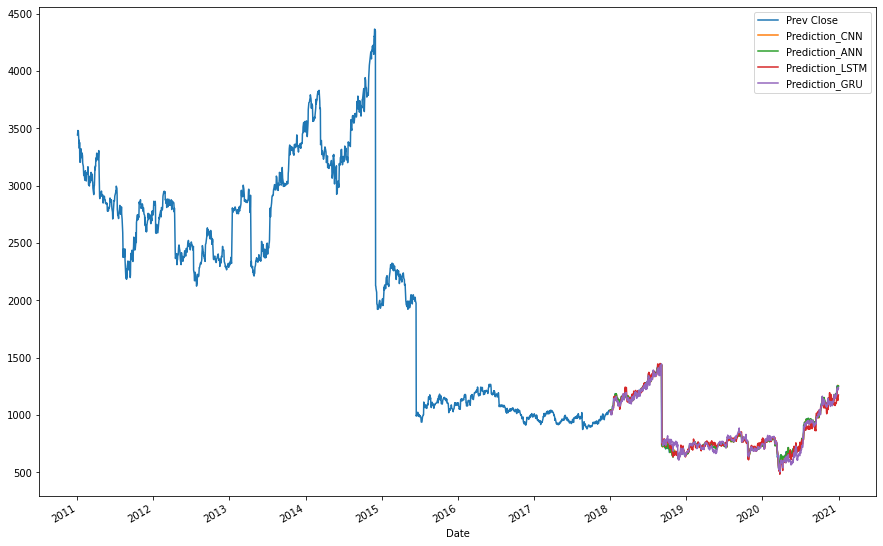

In [103]:
df[[ 'Prev Close','Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10));

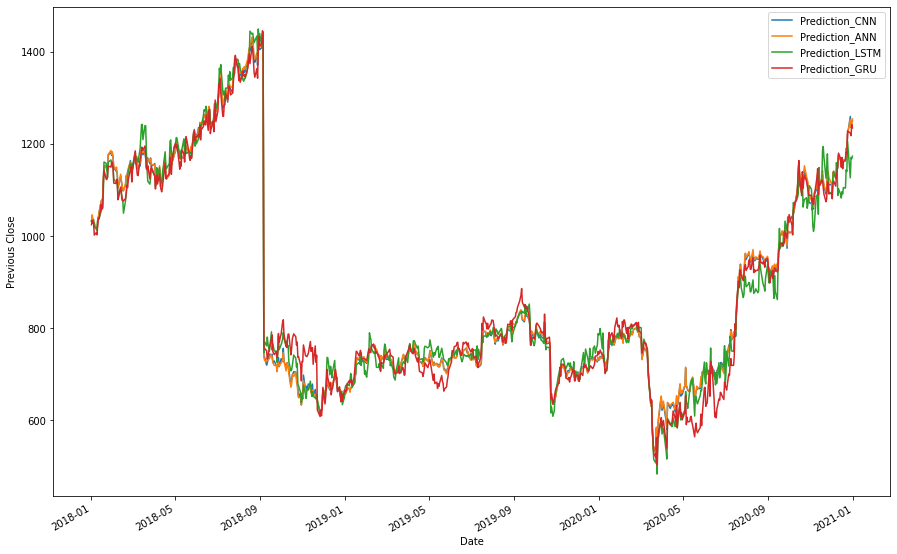

In [104]:
df[[ 'Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10),
    ylabel=("Previous Close"));

Evaluation

In [105]:
pred_ann=df['Prediction_ANN']
pred_ann.dropna(inplace=True)

In [106]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_ann))
print(rmse)

30.2209785632345


In [107]:
error=mean_absolute_error(test['Prev Close'],pred_ann)
print(error)

12.278482685738503


In [108]:
r2_score(test['Prev Close'],pred_ann)

0.9821604202395332

In [109]:
pred_cnn=df['Prediction_CNN']
pred_cnn.dropna(inplace=True)

In [110]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_cnn))
print(rmse)

30.195175916573493


In [111]:
error=mean_absolute_error(test['Prev Close'],pred_cnn)
print(error)

12.460926981777964


In [112]:
r2_score(test['Prev Close'],pred_cnn)

0.9821908700720375

In [113]:
pred_lstm=df['Prediction_LSTM']
pred_lstm.dropna(inplace=True)

In [114]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm))
print(rmse)

40.81795851884317


In [115]:
error=mean_absolute_error(test['Prev Close'],pred_lstm)
print(error)

24.886997511540194


In [116]:
r2_score(test['Prev Close'],pred_lstm)

0.9674560597375661

In [117]:
pred_gru=df['Prediction_GRU']
pred_gru.dropna(inplace=True)

In [118]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_gru))
print(rmse)

43.35648093638985


In [119]:
error=mean_absolute_error(test['Prev Close'],pred_gru)
print(error)

26.35736902669814


In [120]:
r2_score(test['Prev Close'],pred_gru)

0.9632822868843813